# Standard Autoencoder

## Setup

### Imports

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

from autoencoders.autoencoder import Autoencoder
from utils.stacked_mnist import StackedMNISTData, DataMode
from utils.verification_net import VerificationNet


### Configuration

In [3]:
encoding_dim = 16
epochs = 50
batch_size = 256
force_relearn = False
mono_tolerance = 0.8
stacked_tolerance = 0.5
n_generated = 10000

### Verification network

In [ ]:
# Train verification network
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=epochs)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = net.check_class_coverage(data=img, tolerance=.98)
pred, acc = net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

D:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Coverage: 100.00%
Predictability: 98.39%
Accuracy: 98.14%


## Mono MNIST

### Data

In [4]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Train

In [5]:
# Train autoencoder
autoencoder = Autoencoder(encoding_dim, x_train.shape[1:3])
autoencoder.summary()
autoencoder.train(x_train, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          200768    
_________________________________________________________________
flatten (Flatten)            (None, 64)                0   

True

### Reconstruction

**Reconstruct images and display**

In [7]:
encoded = autoencoder.encode(x_test)
reconstructed = autoencoder(x_test)

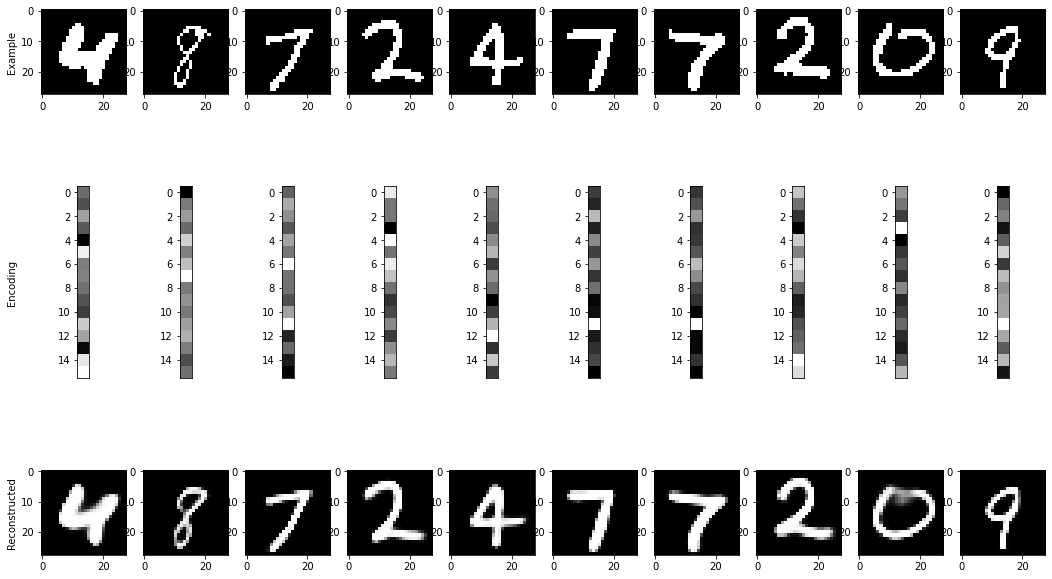

In [8]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test.shape[0], n_display, replace=False)
fig, ax = plt.subplots(3, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test[n], cmap='gray')
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed[n], cmap='gray')
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

**Assess reconstructions**

In [9]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=reconstructed, tolerance=mono_tolerance)
pred, acc = net.check_predictability(data=reconstructed, correct_labels=y_test, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 92.43%
Accuracy: 89.99%


### Generation

**Generate images and display**

In [10]:
z = np.random.randn(n_generated, encoding_dim, 1)
generated = autoencoder.decode(z)

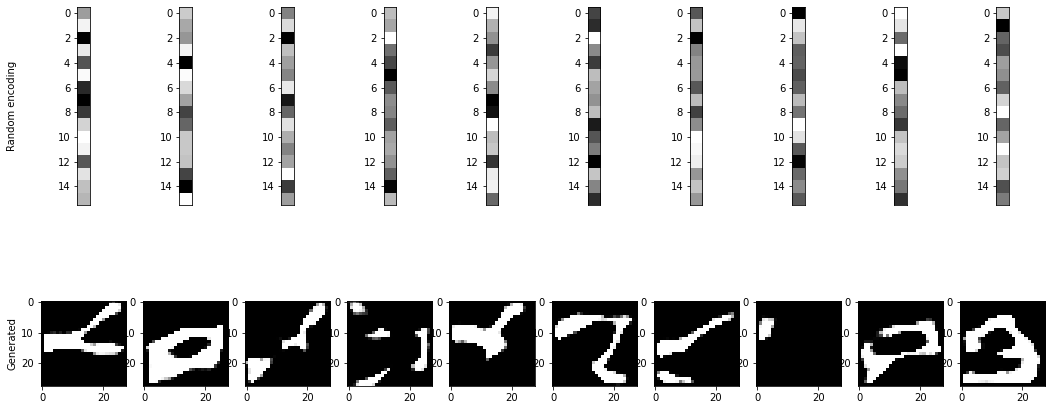

In [11]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(2, n_display, figsize=(18, 8))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated[n], cmap='gray')

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()

**Assess generation**

In [12]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=generated, tolerance=mono_tolerance)
pred, _ = net.check_predictability(data=generated, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 52.55%


### Anomaly Detection

**Train new model**

In [13]:
missing_gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)

# Train autoencoder
x_train_missing, y_train_missing = missing_gen.get_full_data_set(training=True)

missing_autoencoder = Autoencoder(encoding_dim, x_train_missing.shape[1:3], file_name="./models/missing_autoencoder/autoencoder")
missing_autoencoder.summary()
missing_autoencoder.train(x_train_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 1, 64)          200768    
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0   

True

In [33]:
# Calculating reconstruction losses with test set with no missing digits
loss = missing_autoencoder.reconstruction_loss(x_test)

(10000, 28, 28, 1)


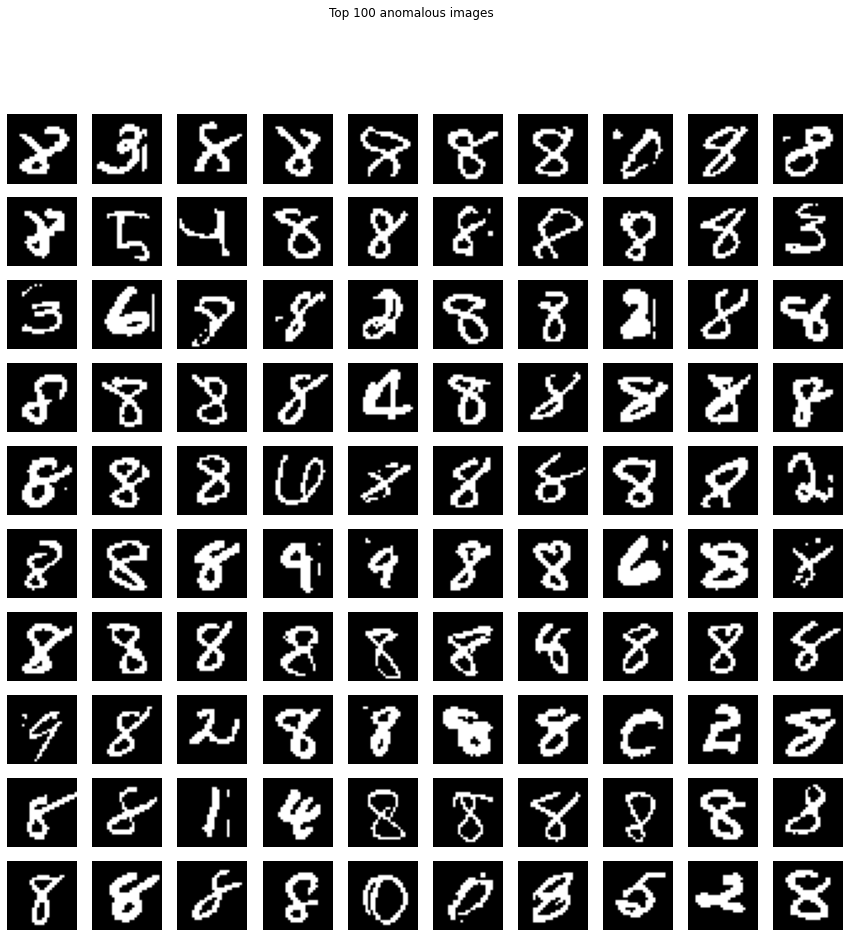

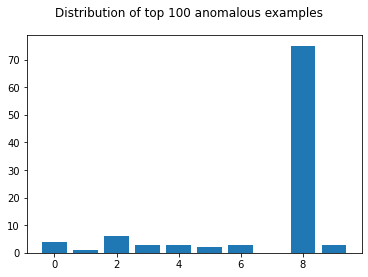

10 most anomolous labels: [8 3 8 8 8 8 8 0 8 8]


In [35]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()
unique, counts = np.unique(y_test[idx], return_counts=True)
fig, ax = plt.subplots()
ax = plt.bar(unique, counts)
fig.suptitle(f'Distribution of top {grid_size**2} anomalous examples')
plt.show()
print('10 most anomolous labels:', y_test[idx][:10])

## Color MNIST

### Data

In [17]:
color_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)
x_train_color, y_train_color = color_gen.get_full_data_set(training=True)
x_test_color, y_test_color = color_gen.get_full_data_set(training=False)

### Train

In [18]:
color_autoencoder = Autoencoder(encoding_dim=encoding_dim, image_dim=x_train_color.shape[1:3], file_name='./models/color_autoencoder/autoencoder')
color_autoencoder.summary()
color_autoencoder.train(x_train_color, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 64)          200768    
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0   

True

### Reconstruction

**Reconstruct images and display**

In [19]:
encoded = color_autoencoder.encode(x_test_color)
reconstructed = color_autoencoder(x_test_color)

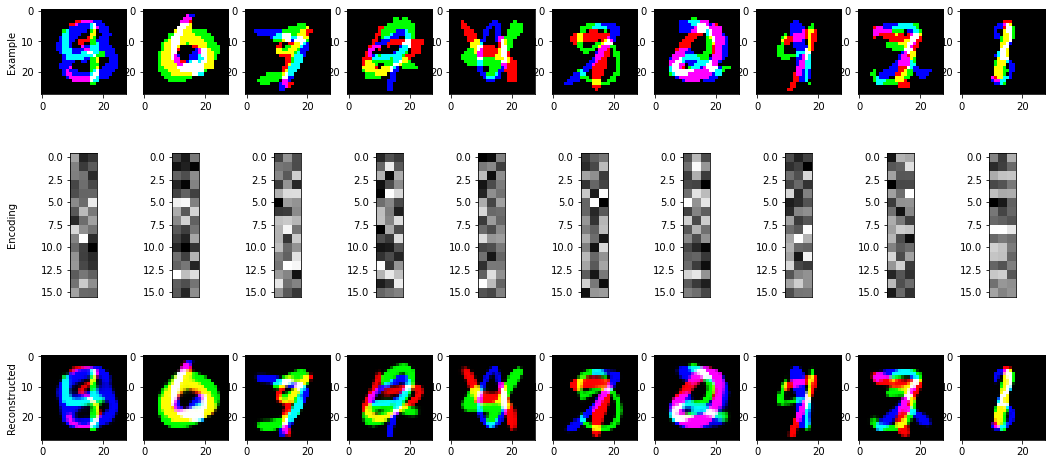

In [20]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test_color.shape[0], n_display, replace=False)
fig, ax = plt.subplots(3, n_display, figsize=(18, 9))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test_color[n] * 255)
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed[n])
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

**Assess reconstruction**

In [21]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=reconstructed, tolerance=stacked_tolerance)
pred, acc = net.check_predictability(data=reconstructed, correct_labels=y_test_color, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 94.96%
Accuracy: 86.17%


### Generation

**Generate images and display**

In [22]:
z = np.random.randn(n_generated, encoding_dim, 3)
generated = autoencoder.decode(z)

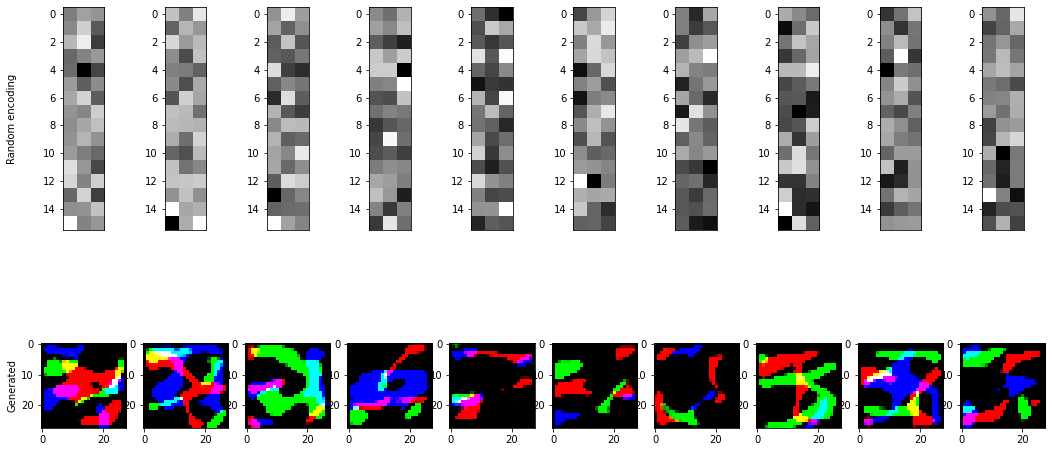

In [23]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(2, n_display, figsize=(18, 9))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated[n])

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()

**Assess generation**

In [24]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=generated, tolerance=stacked_tolerance)
pred, _ = net.check_predictability(data=generated, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 37.30%
Predictability: 33.49%


### Anomaly Detection

**Train new model**

In [25]:
color_missing_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING)

# Train autoencoder
x_train_color_missing, y_train_color_missing = color_missing_gen.get_full_data_set(training=True)

color_missing_autoencoder = Autoencoder(encoding_dim, x_train_color_missing.shape[1:3], file_name="./models/color_missing_autoencoder/autoencoder")
color_missing_autoencoder.summary()
color_missing_autoencoder.train(x_train_color_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 1, 64)          200768    
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0   

True

In [26]:
# Calculating reconstruction losses with test set with no missing digits
loss = color_missing_autoencoder.reconstruction_loss(x_test_color)

(10000, 28, 28, 3)


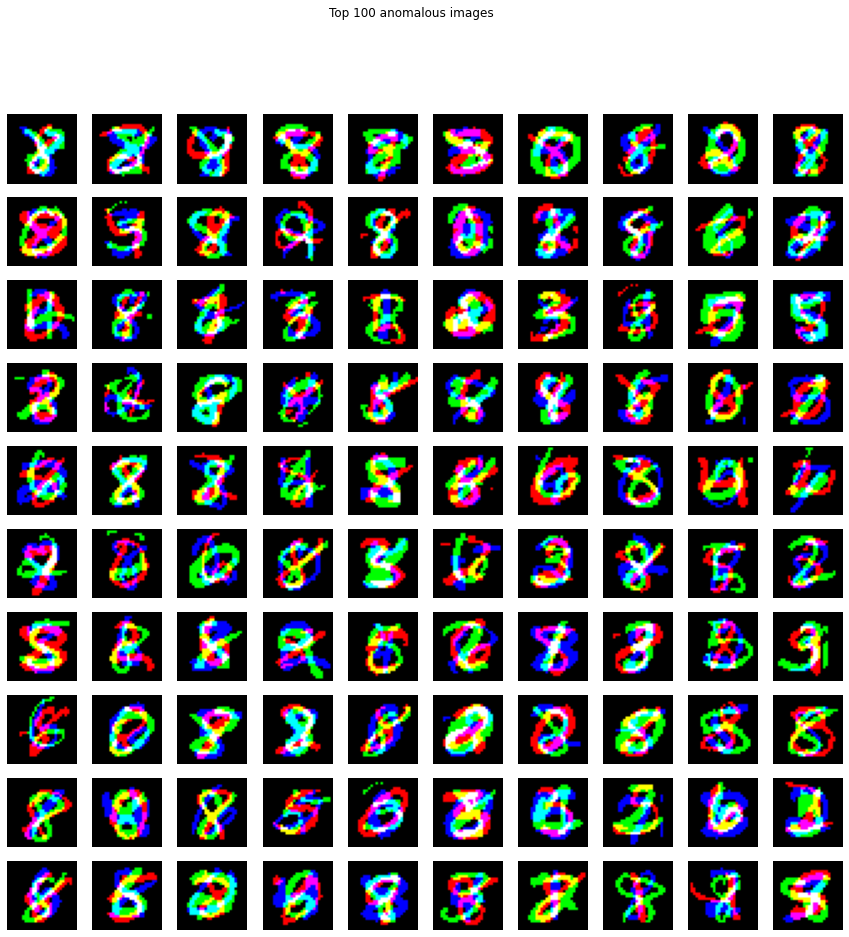

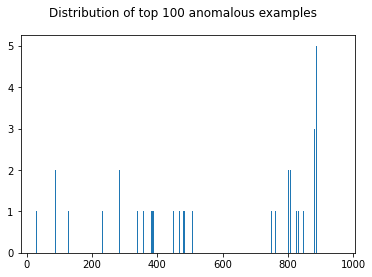

10 most anomolous labels: [888 882 884 388  89 328 808 880 802 888]


In [31]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test_color[idx[grid_size*n + m]]*255)
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()
unique, counts = np.unique(y_test_color[idx], return_counts=True)
fig, ax = plt.subplots()
ax = plt.bar(unique, counts)
fig.suptitle(f'Distribution of top {grid_size**2} anomalous examples')
plt.show()
print('10 most anomolous labels:', y_test_color[idx][:10])